In [180]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [181]:
words = []
word_vectors = []

In [182]:
with open('hw3/nmt-en-dec-512.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        splitted = line.split()
        word = splitted[0]
        vector = [float(el) for el in splitted[1:]]
        vector = np.array(vector)
        
        words.append(word)
        word_vectors.append(vector)

In [183]:
word_vectors = np.array(word_vectors)

In [184]:
word_vectors.shape

(5000, 512)

In [185]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  verbose=1,
                  init='random').fit_transform(word_vectors)
print(X_embedded.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.820730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.343170
[t-SNE] KL divergence after 1000 iterations: 2.505703
(5000, 2)


In [186]:
def plot_word_embeddings(embeddings, 
                         color="#C1E3B8", 
                         fontsize=12,
                         annotation_freq=50, 
                         seed=1234, 
                         first_dim=0, 
                         second_dim=1):
    plt.figure(figsize=(15, 12))
    plt.scatter(embeddings[:, first_dim], embeddings[:, second_dim], c=color)
    
    np.random.seed(seed)
    indices = np.random.choice(embeddings.shape[0], annotation_freq, replace=False)  
    
    for i in indices:
        y = embeddings[i]
        word_label = words[i]
        plt.annotate(word_label, (y[first_dim], y[second_dim]), fontsize=fontsize)

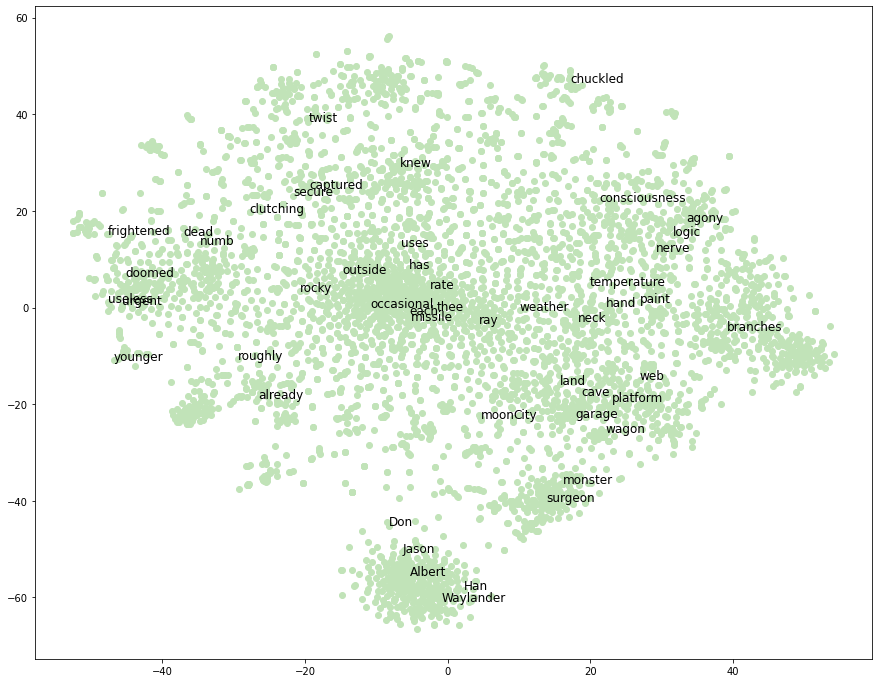

In [187]:
X = word_vectors
Y = X_embedded

plot_word_embeddings(Y)

# Task 2

Cluster the word vectors in the original 512-dimensional vector space using the methods of K-means, GaussianMixture, and Aglomerative clustering. Use the functions implemented in the `sklearn` library. Try different
number of clusters (3,5,10) and different linkage strategies (ward, single, complete). Visualize the clusters using different colors in T-SNE. Compute the Silhouette coeficients of the individual clusterings. Use `sklearn.metrics.silhouette_score`. What method is the best? What
methods failed? 

In [188]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph, NearestCentroid

from matplotlib import cm

In [189]:
def cluster(X, method, n_clusters, linkage_strategy=None):
    n_neighbors = 10
    
    clusterer = None
    if method == "K-means":
        clusterer = KMeans(
            n_clusters=n_clusters, 
            init='random',
            n_init=10, 
            max_iter=300, 
            tol=1e-04, 
            random_state=1
        )
    
    elif method == "Gaussian Mixture":
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="full")
        
    elif method == "Agglomerative Clustering":
        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=n_neighbors, include_self=False
        )
        # make connectivity symmetric
        #connectivity = 0.5 * (connectivity + connectivity.T)

        clusterer = AgglomerativeClustering(
            linkage=linkage_strategy,
            #affinity="cityblock",
            n_clusters=n_clusters,
            connectivity=connectivity,
        )
    else:
        print("ERROR")
    
    return clusterer, clusterer.fit_predict(X)

In [190]:
def plot_clusters(X, Y, n_clusters, method, sample_silhouette_values):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    silhouette_avg_str = "{:.5f}".format(silhouette_avg)
    ax1.set_title("The silhouette plot for the various clusters. Avg. sillhouette score: " + silhouette_avg_str)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    #if method == "K-means":
    #    centers = clusterer.cluster_centers_
    #elif method == "Gaussian Mixture":
    #    centers = clusterer.means_
    #else:
    #    clf = NearestCentroid()
    #    clf.fit(X, Y)
    #    centers = clf.centroids_
    
    # Draw white circles at cluster centers
    #ax2.scatter(
    #    centers[:, 0],
    #    centers[:, 1],
    #    marker="o",
    #    c="white",
    #    alpha=1,
    #    s=200,
    #    edgecolor="k",
    #)

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    if method == "Agglomerative Clustering":
        subtitle = "Silhouette analysis for {} clustering using {} linkage strategy with n_clusters = {}".format(method, linkage_strategy, n_clusters)
    else:
        subtitle = "Silhouette analysis for {} clustering with n_clusters = {}".format(method, n_clusters)
    plt.suptitle(subtitle, fontsize=14, fontweight="bold")

For n_clusters =  3 the average silhouette_score is: 0.033828204158780115
For n_clusters =  5 the average silhouette_score is: 0.03459523947851218
For n_clusters = 10 the average silhouette_score is: 0.02732128801749716
For n_clusters =  3 the average silhouette_score is: 0.03380787355025598
For n_clusters =  5 the average silhouette_score is: 0.029000018533540697
For n_clusters = 10 the average silhouette_score is: 0.028977982915093424
For n_clusters =  3 (linkage strategy: ward) the average silhouette_score is: 0.02506865796935428
For n_clusters =  5 (linkage strategy: ward) the average silhouette_score is: 0.023781375782857883
For n_clusters = 10 (linkage strategy: ward) the average silhouette_score is: 0.00967672203769523
For n_clusters =  3 (linkage strategy: single) the average silhouette_score is: 0.3999057045328436
For n_clusters =  5 (linkage strategy: single) the average silhouette_score is: 0.3380703302647055
For n_clusters = 10 (linkage strategy: single) the average silhoue

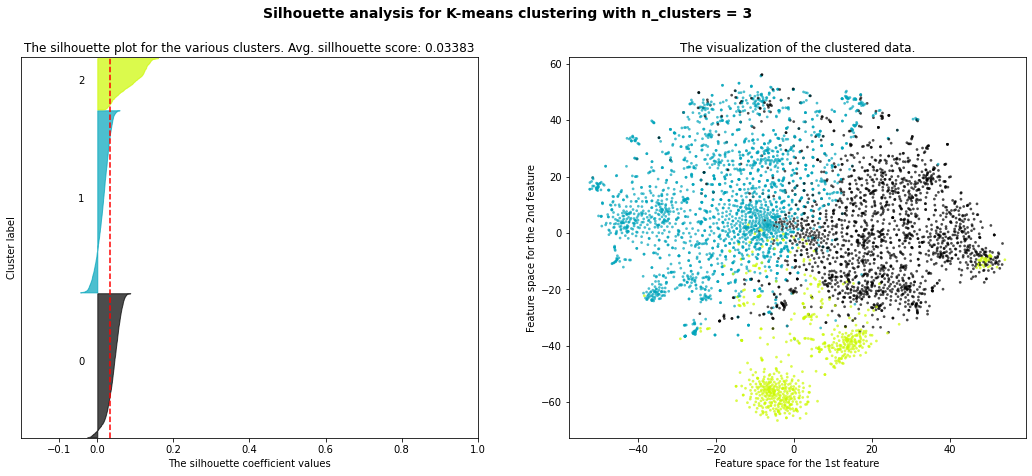

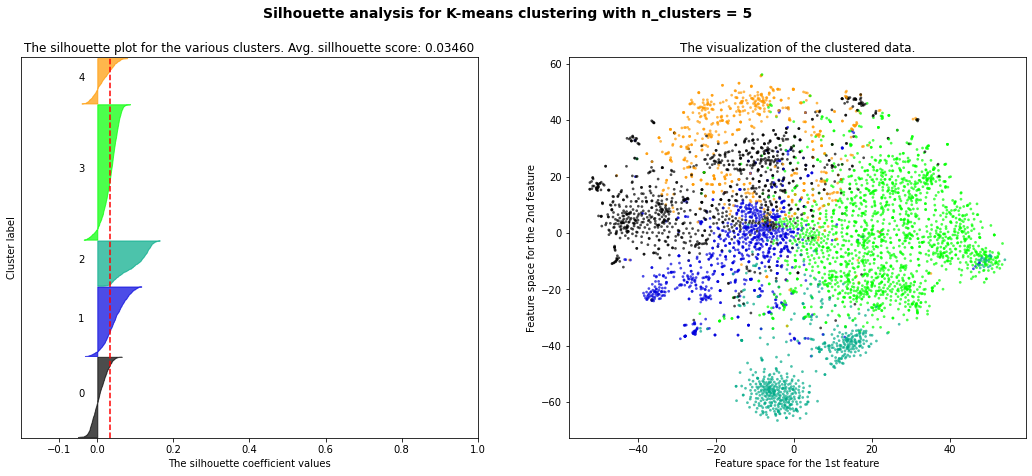

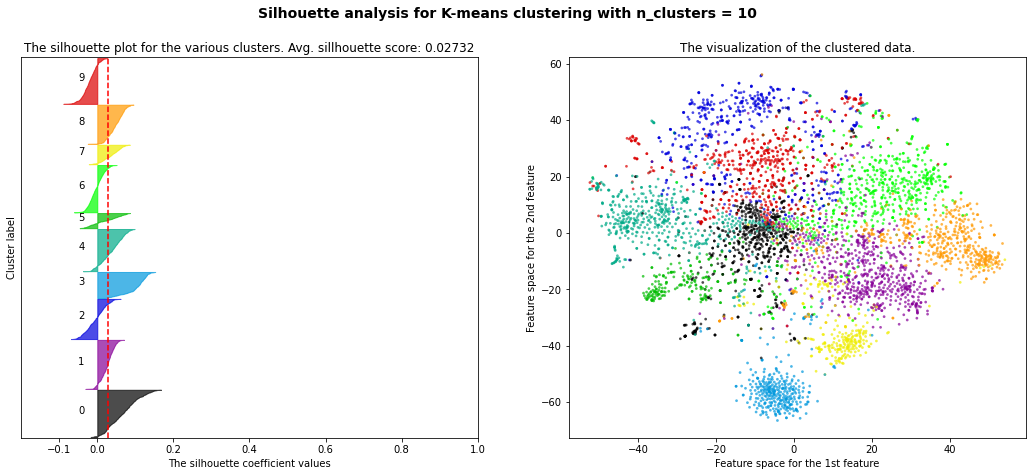

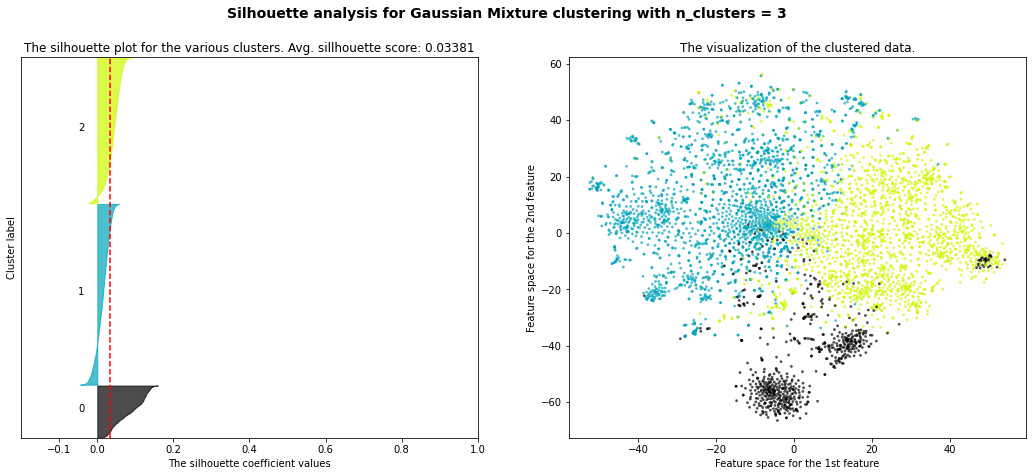

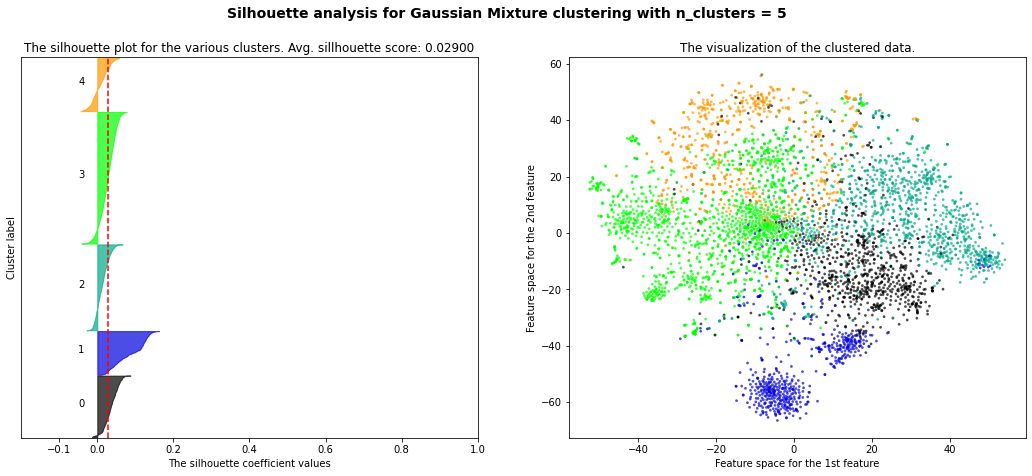

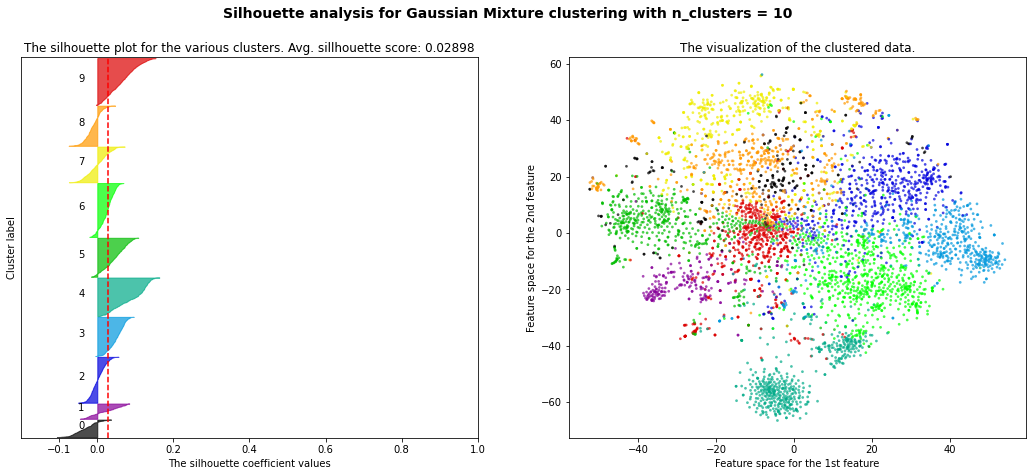

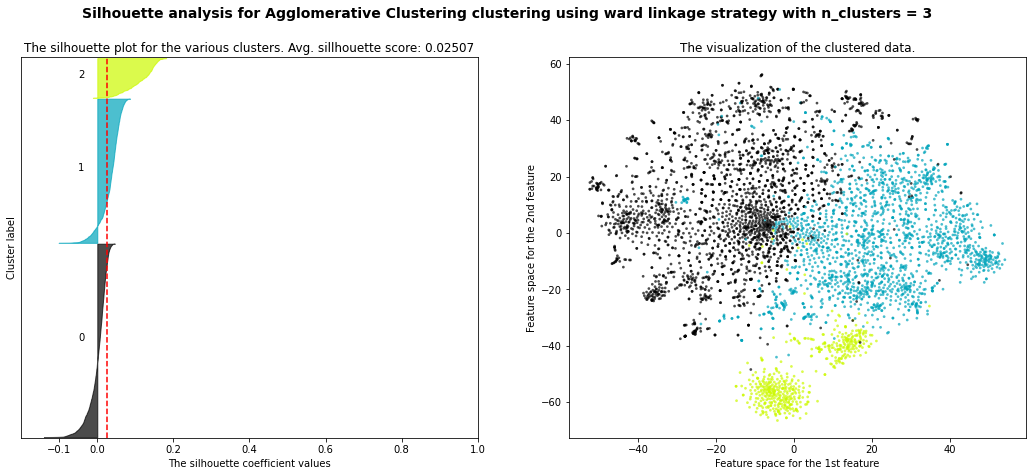

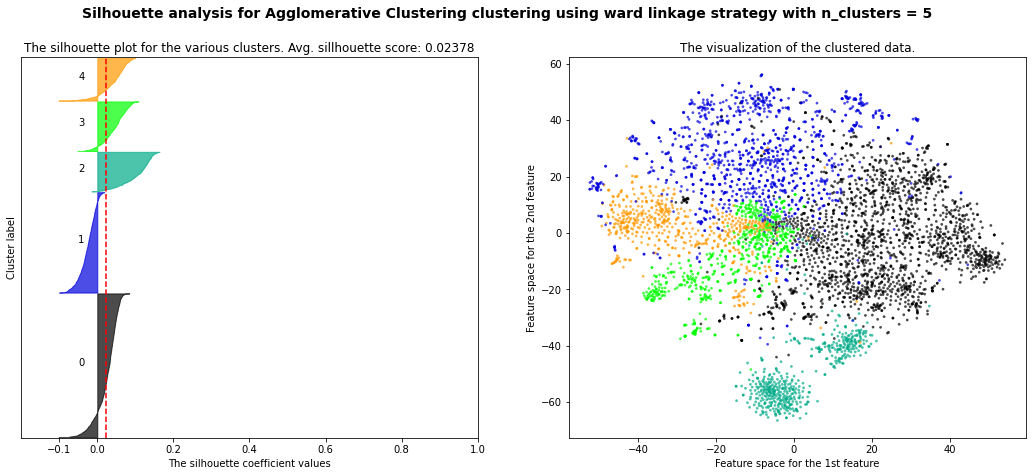

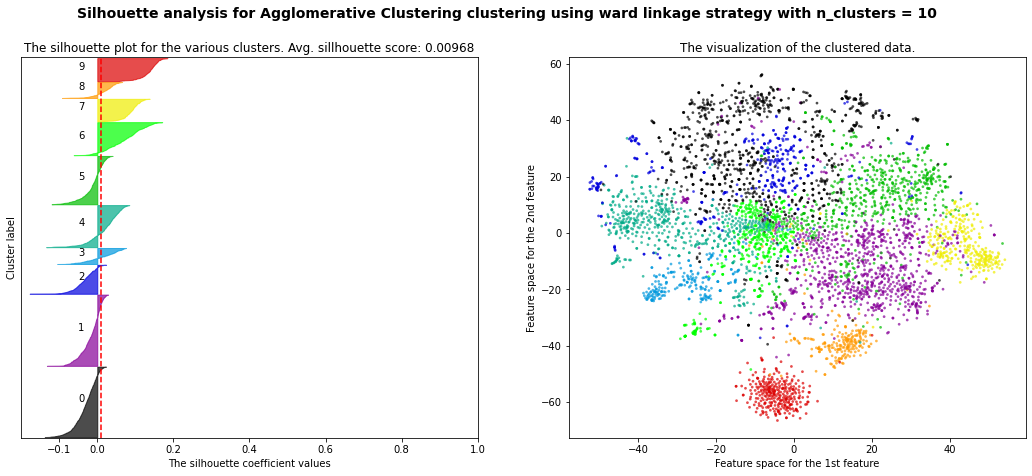

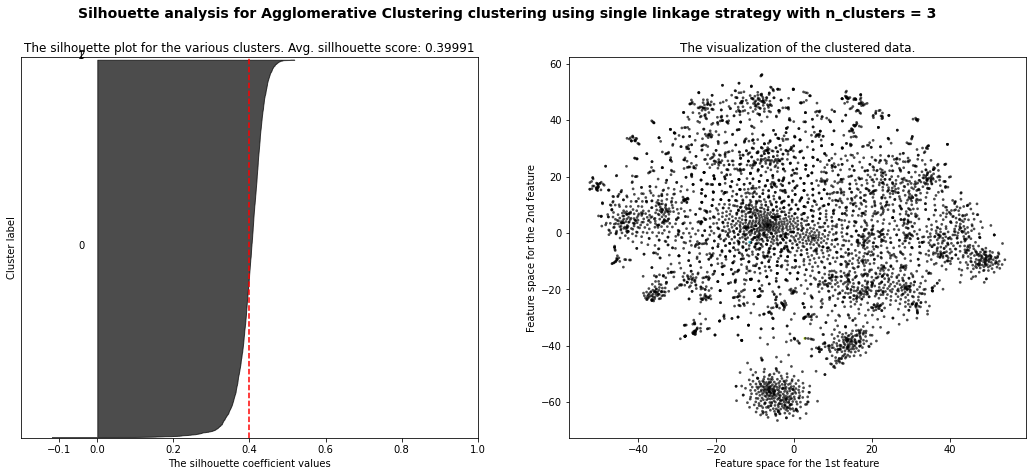

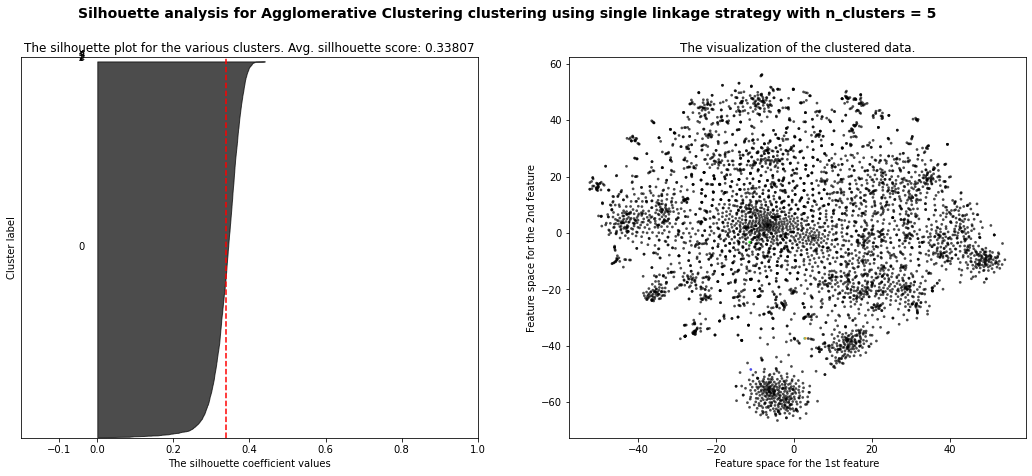

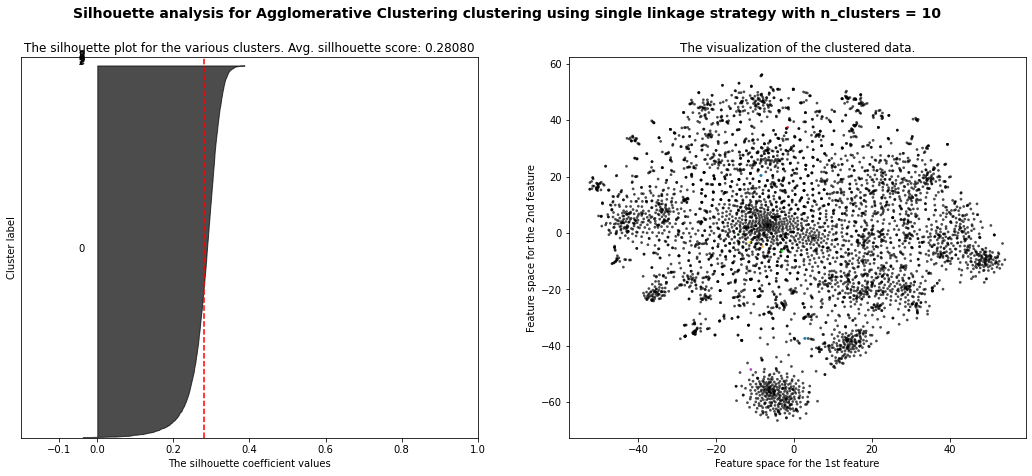

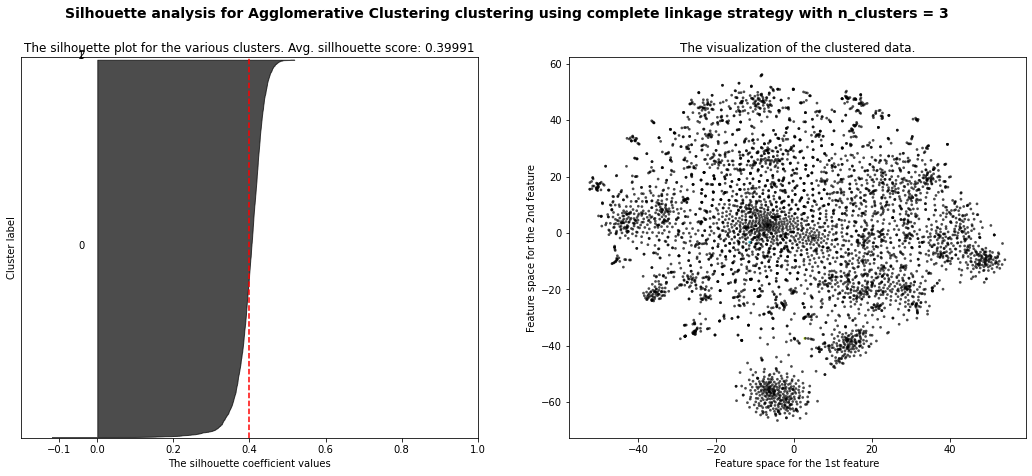

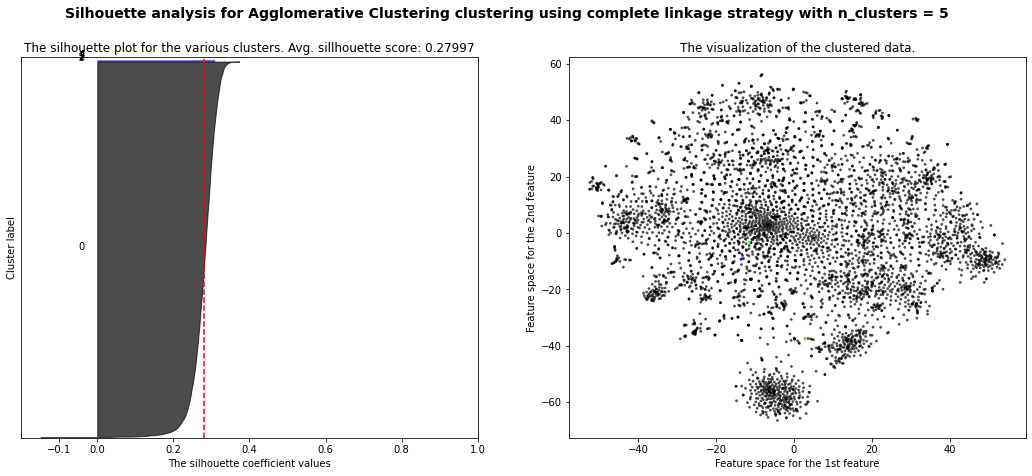

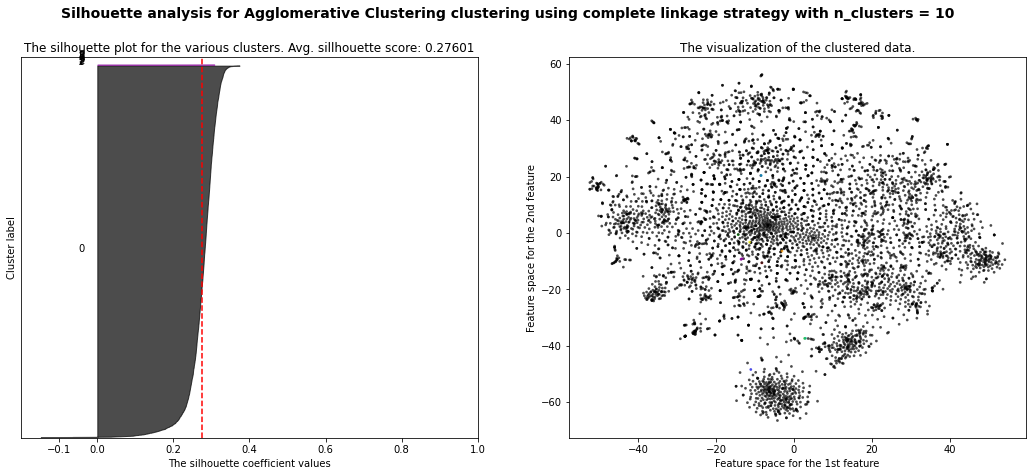

In [191]:
range_n_clusters = [3, 5, 10]
methods = ['K-means', 'Gaussian Mixture', 'Agglomerative Clustering']
linkage_strategies = ["ward", "single", "complete"]

results = []

for method in methods:
    for linkage_strategy in linkage_strategies:
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer, cluster_labels = cluster(X, method, n_clusters, linkage_strategy)

            silhouette_avg = silhouette_score(X, cluster_labels)
            if method == "Agglomerative Clustering":
                print("For n_clusters = {0:2} (linkage strategy: {1}) the average silhouette_score is: {2}".format(n_clusters, linkage_strategy, silhouette_avg))
            else:
                print("For n_clusters = {0:2} the average silhouette_score is: {1}".format(n_clusters, silhouette_avg))
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            plot_clusters(X_embedded, cluster_labels, n_clusters, method, sample_silhouette_values)

            results.append({
                "method" : method,
                "n_clusters": n_clusters,
                "linkage_strategy": linkage_strategy,
                "silhouette_score": silhouette_avg
            })
        if method != "Agglomerative Clustering":
            break
plt.show()

In [193]:
import pandas as pd

df = pd.DataFrame.from_records(results)

In [194]:
df

method  n_clusters linkage_strategy  silhouette_score
0                    K-means           3             ward          0.033828
1                    K-means           5             ward          0.034595
2                    K-means          10             ward          0.027321
3           Gaussian Mixture           3             ward          0.033808
4           Gaussian Mixture           5             ward          0.029000
5           Gaussian Mixture          10             ward          0.028978
6   Agglomerative Clustering           3             ward          0.025069
7   Agglomerative Clustering           5             ward          0.023781
8   Agglomerative Clustering          10             ward          0.009677
9   Agglomerative Clustering           3           single          0.399906
10  Agglomerative Clustering           5           single          0.338070
11  Agglomerative Clustering          10           single          0.280803
12  Agglomerative Clustering           3         complete          0.399906
13  Agglomerative Clustering           5         complete          0.279969
14  Agglomerative Clustering          10         complete          0.276007

The methods that failed are Agglomerative Clustering with complete and single linkage strategy.

The best method is Gaussian Mixture with 5 clusters, with K-means with 5 clusters not too far behind.

# Task 3

Perform the Principal Component Analysis on the data (use the function `sklearn.decomposition.PCA`). Visualise the data transformed into the first two principal components. Try to guess what features of words are represented by the first two components. Run the K-Means, Gaussian-Mixture, and Aglomerative clustering on the data transformed into the first two PCA componens. Compute the Silhouette coeficients and find the best number of clusters. Why the silhouette coeficients are so different from those in Task 2?

In [197]:
from sklearn.decomposition import PCA

In [198]:
pca = PCA(n_components=5)
X_PCA_transformed = pca.fit_transform(X)
print(X_PCA_transformed.shape)

(5000, 5)


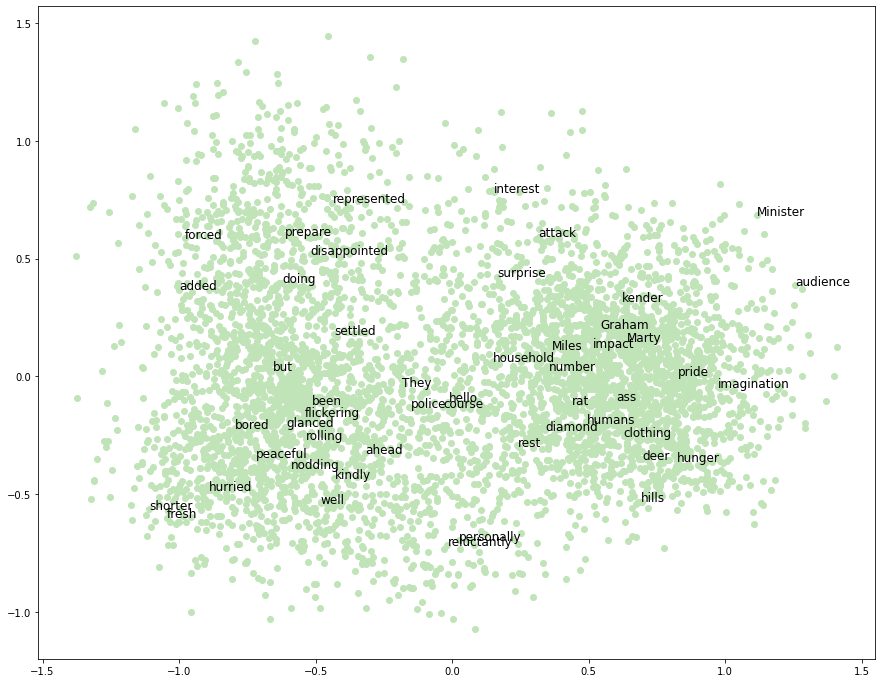

In [199]:
plot_word_embeddings(X_PCA_transformed, seed=42, first_dim=0, second_dim=4)

For n_clusters =  3 the average silhouette_score is: 0.03453145864188038
For n_clusters =  5 the average silhouette_score is: 0.0337977456848251
For n_clusters = 10 the average silhouette_score is: 0.019435025125928367
For n_clusters =  3 the average silhouette_score is: 0.01875161378677681
For n_clusters =  5 the average silhouette_score is: -0.004268157051441745
For n_clusters = 10 the average silhouette_score is: -0.024509433689106932
For n_clusters =  3 (linkage strategy: ward) the average silhouette_score is: 0.028202975518893312
For n_clusters =  5 (linkage strategy: ward) the average silhouette_score is: 0.02011149936425375
For n_clusters = 10 (linkage strategy: ward) the average silhouette_score is: 0.013298111554126421
For n_clusters =  3 (linkage strategy: single) the average silhouette_score is: 0.3999057045328436
For n_clusters =  5 (linkage strategy: single) the average silhouette_score is: 0.3380703302647055
For n_clusters = 10 (linkage strategy: single) the average silho

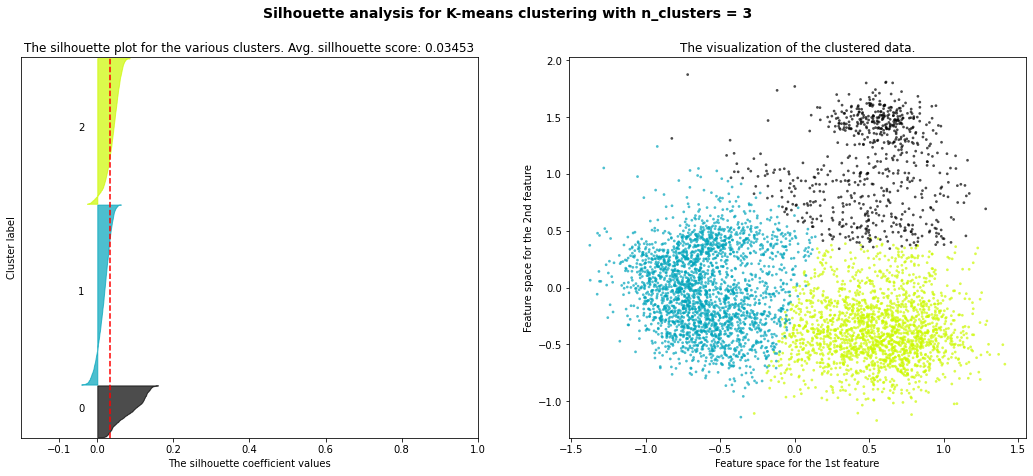

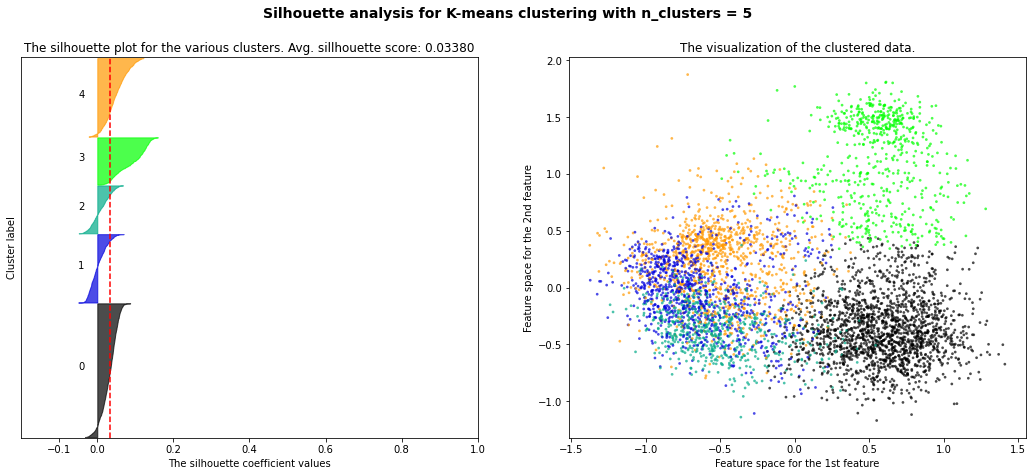

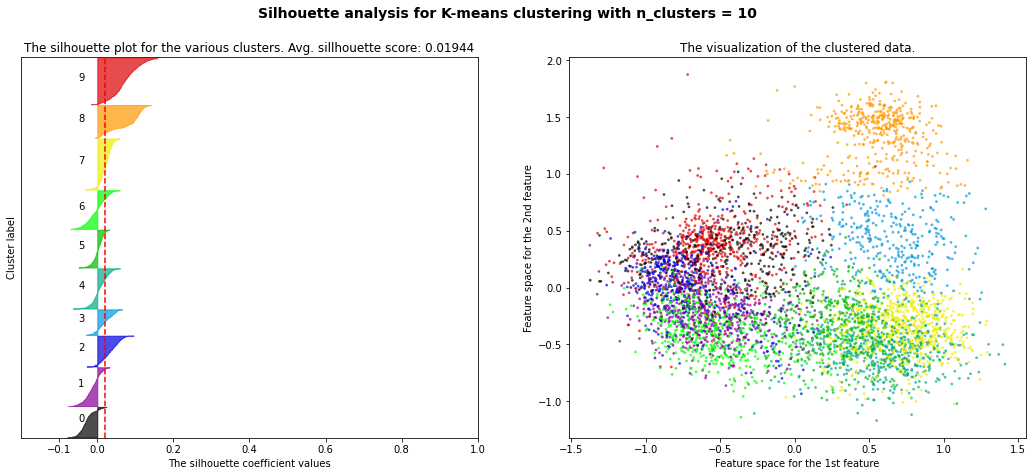

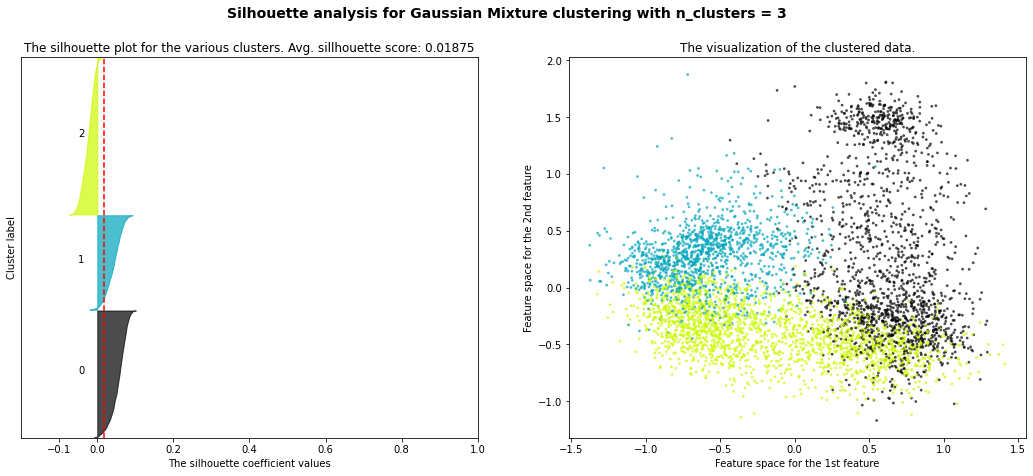

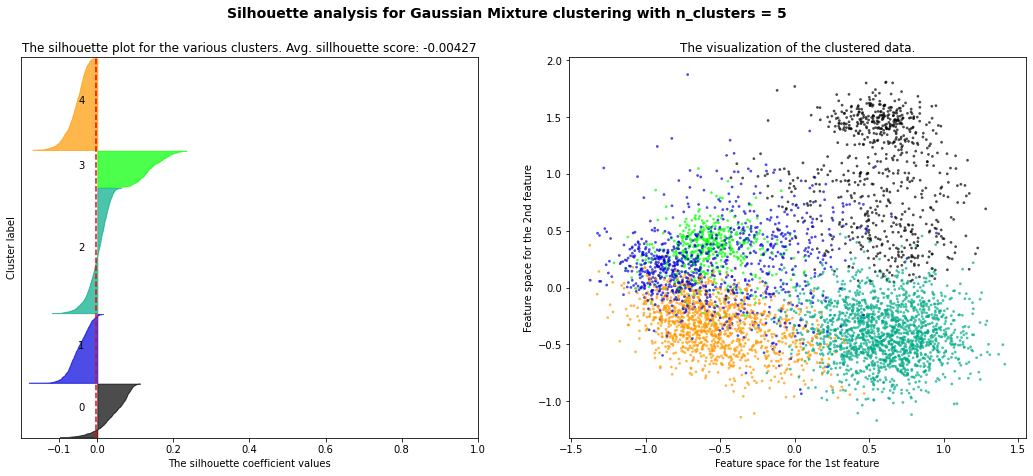

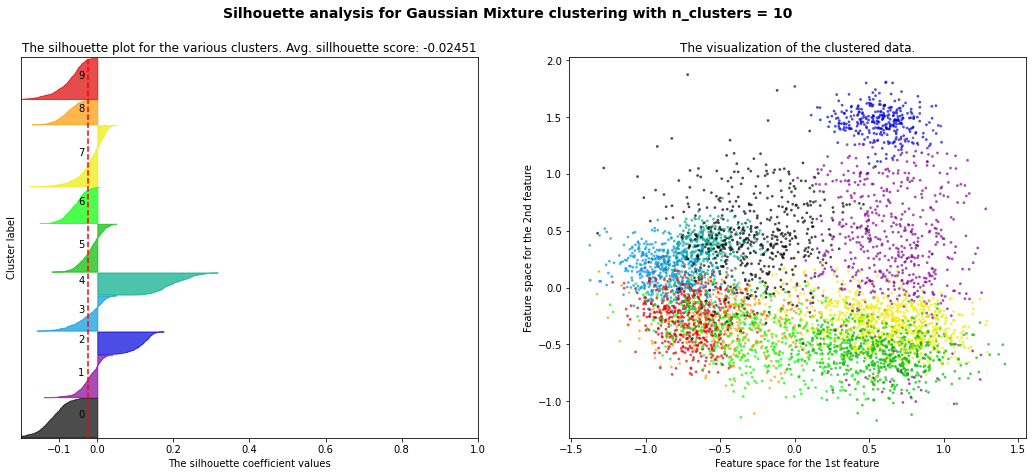

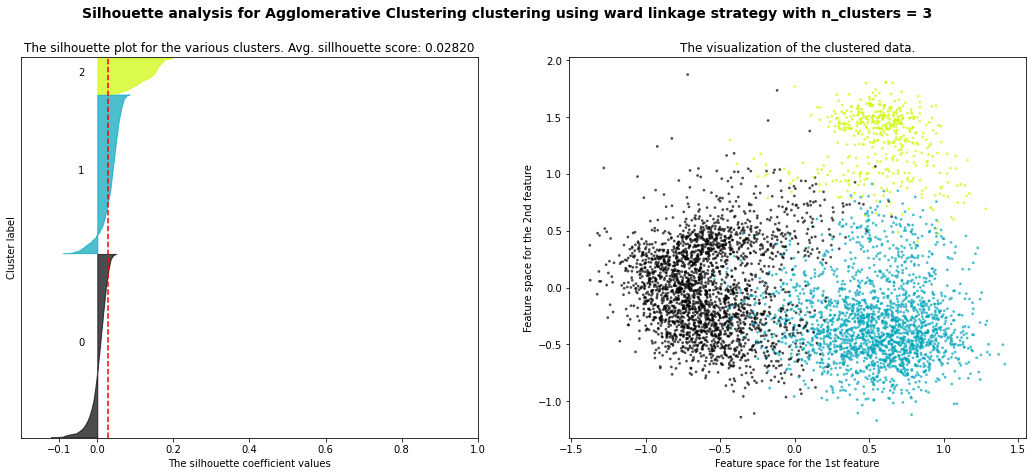

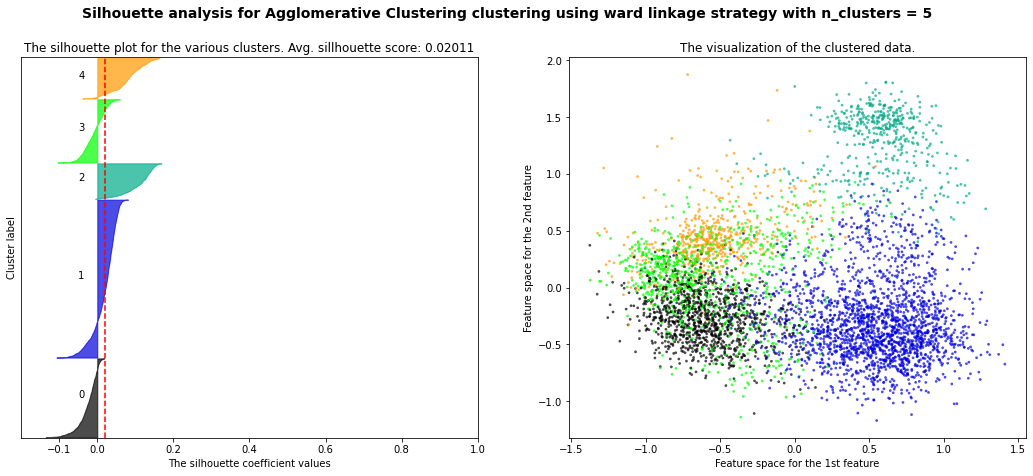

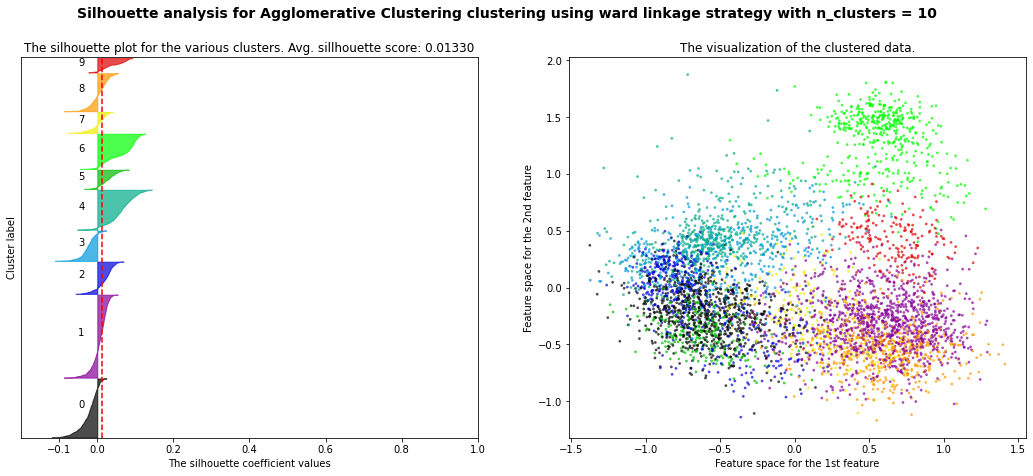

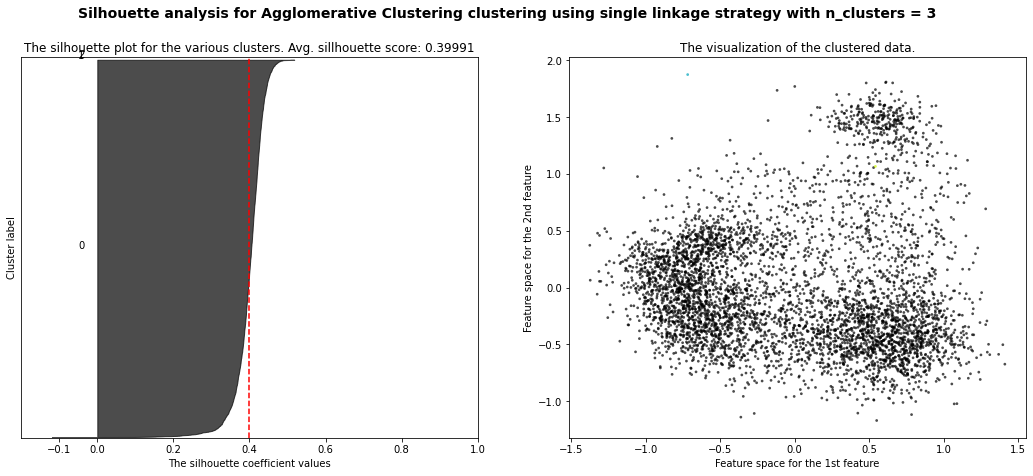

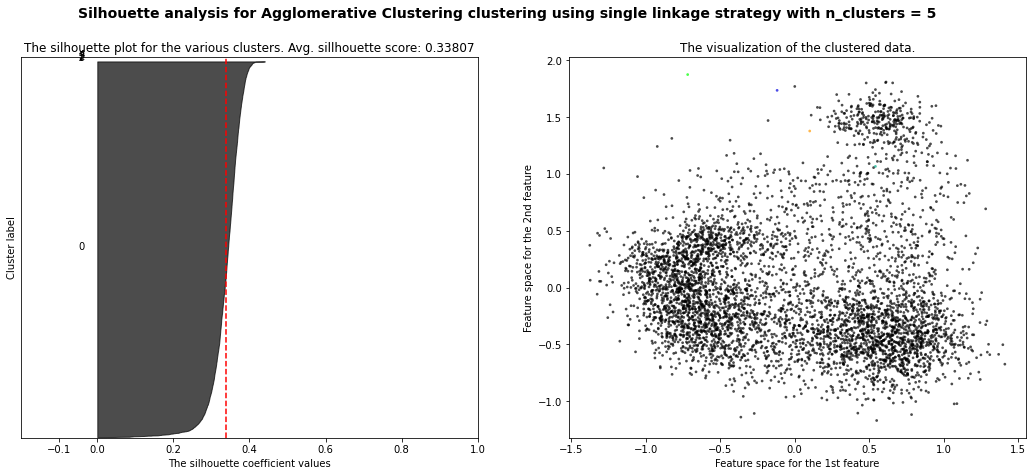

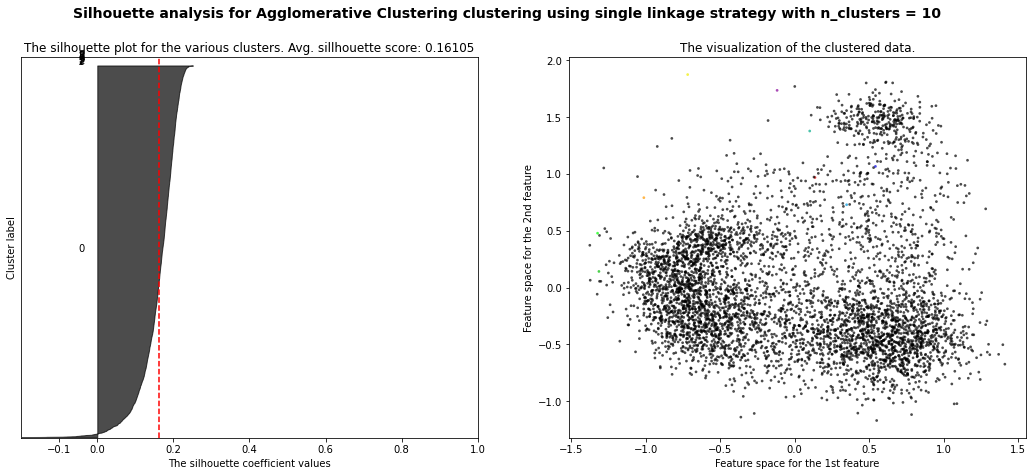

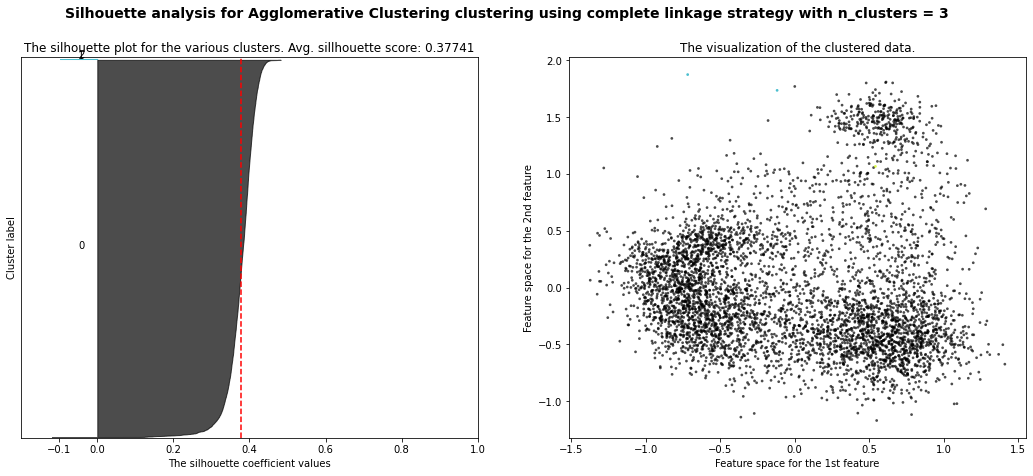

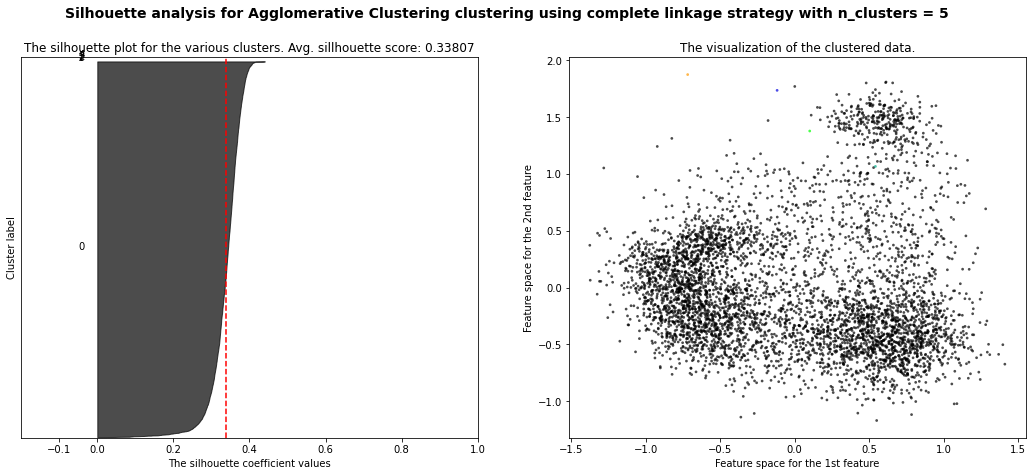

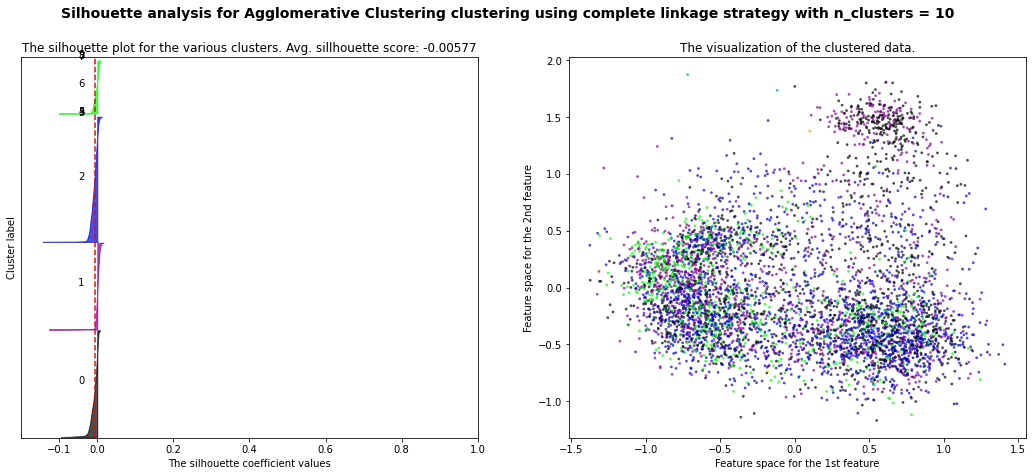

In [168]:
results_after_PCA = []

for method in methods:
    for linkage_strategy in linkage_strategies:
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer, cluster_labels = cluster(X_PCA_transformed, method, n_clusters, linkage_strategy)

            silhouette_avg = silhouette_score(X, cluster_labels)
            if method == "Agglomerative Clustering":
                print("For n_clusters = {0:2} (linkage strategy: {1}) the average silhouette_score is: {2}".format(n_clusters, linkage_strategy, silhouette_avg))
            else:
                print("For n_clusters = {0:2} the average silhouette_score is: {1}".format(n_clusters, silhouette_avg))
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            plot_clusters(X_PCA_transformed, cluster_labels, n_clusters, method, sample_silhouette_values)

            results_after_PCA.append({
                "method" : method,
                "n_clusters": n_clusters,
                "linkage_strategy": linkage_strategy,
                "silhouette_score": silhouette_avg
            })
        if method != "Agglomerative Clustering":
            break
plt.show()

In [152]:
df = pd.DataFrame.from_records(results_after_PCA)
df

method  n_clusters linkage_strategy  silhouette_score
0                    K-means           3             ward          0.034484
1                    K-means           5             ward          0.035027
2                    K-means          10             ward          0.025476
3           Gaussian Mixture           3             ward          0.017817
4           Gaussian Mixture           5             ward         -0.023506
5           Gaussian Mixture          10             ward         -0.019413
6   Agglomerative Clustering           3             ward          0.029686
7   Agglomerative Clustering           5             ward          0.033679
8   Agglomerative Clustering          10             ward          0.015623
9   Agglomerative Clustering           3           single          0.301040
10  Agglomerative Clustering           5           single          0.299620
11  Agglomerative Clustering          10           single          0.144340
12  Agglomerative Clustering           3         complete          0.382435
13  Agglomerative Clustering           5         complete          0.207088
14  Agglomerative Clustering          10         complete          0.000228

# Task 4.

Visualise the first 5 PCA components. Divide each component direction into 100 intervals (bins) and plot 5 bar-charts showing the distribution of words along each component. Label the bars in your bar-chart by words sampled from each bin. Try to explain what features of words are represented by individual PCA components. (2 pts)

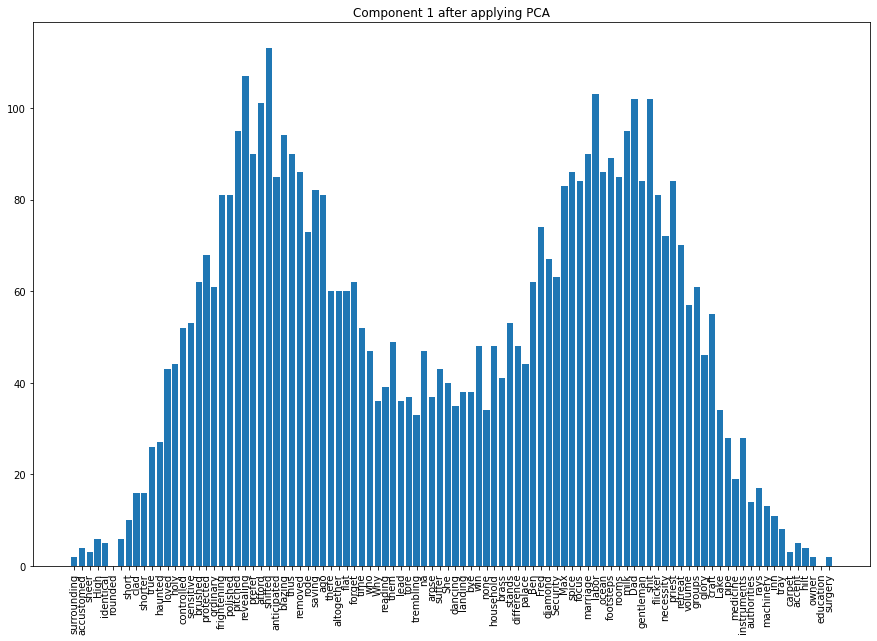

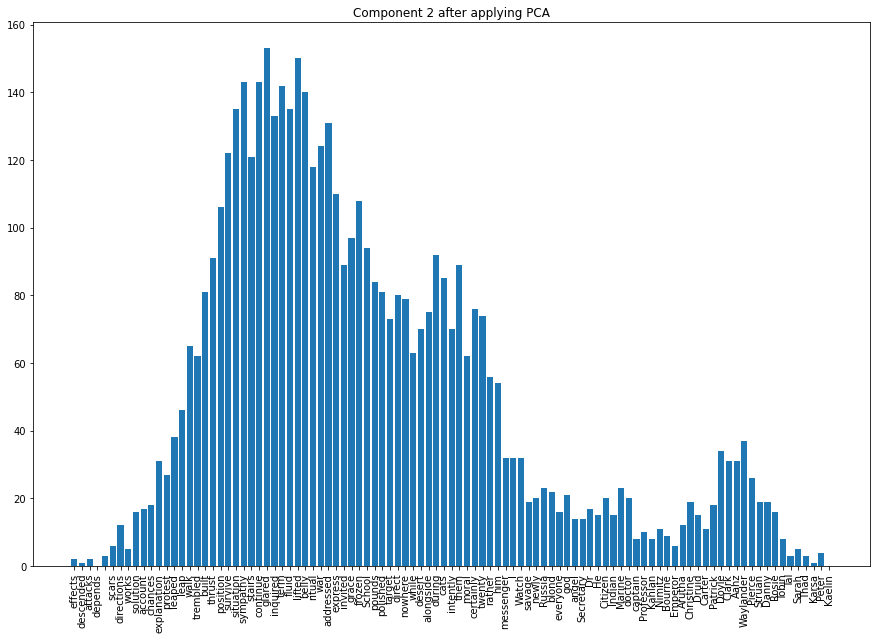

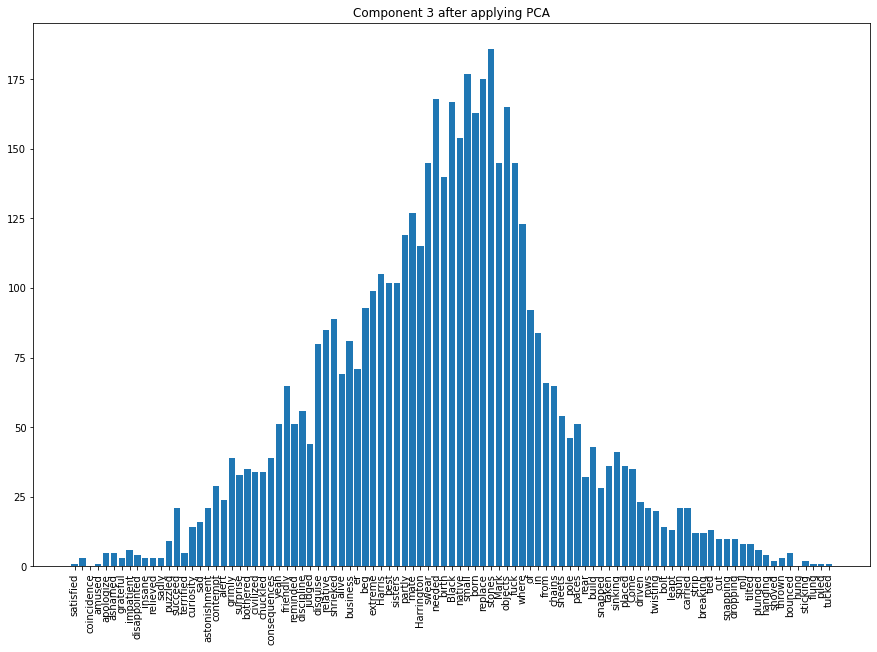

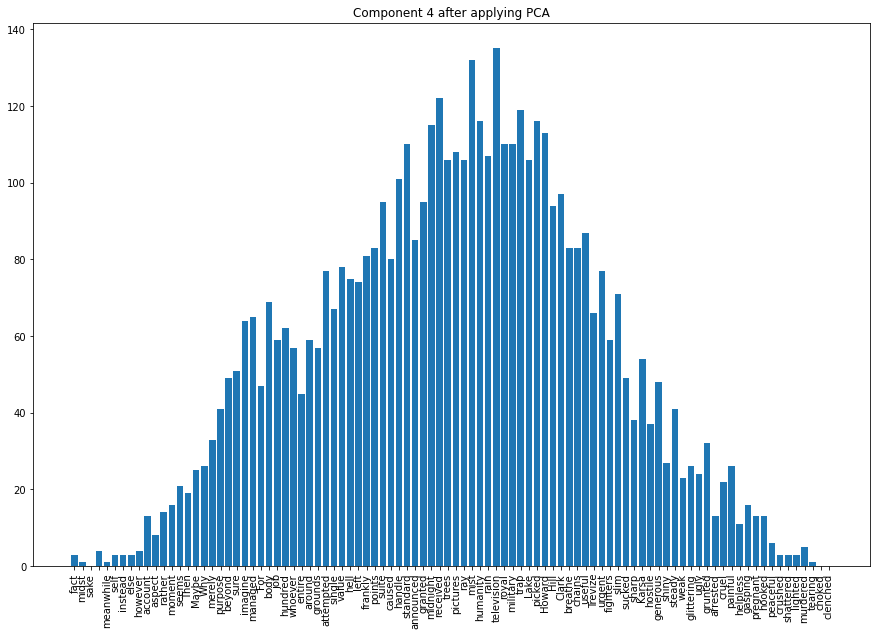

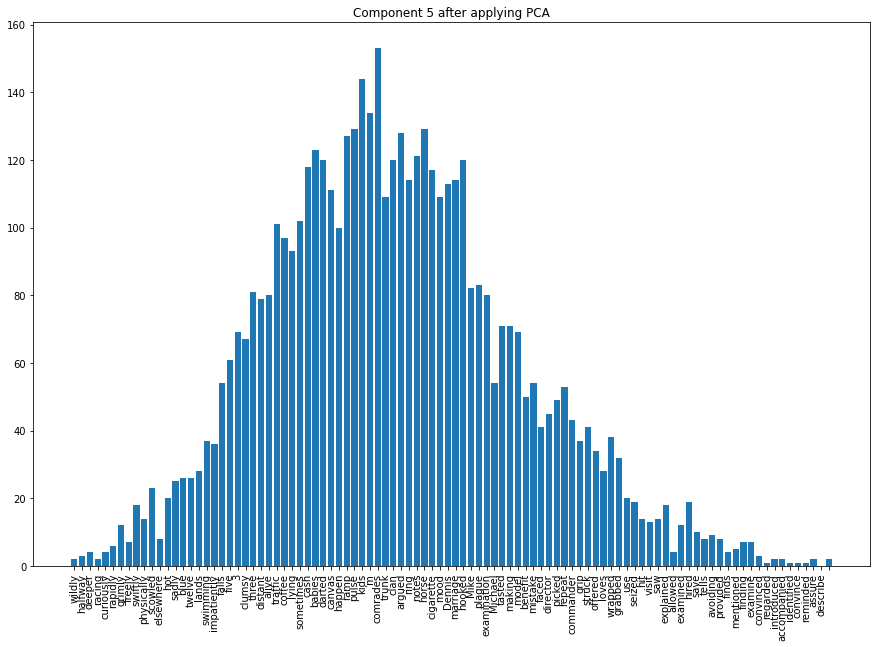

In [228]:
np.random.seed(1234)

for i in range(5):
    component = X_PCA_transformed[:, i]
    
    component_hist, bins_edges = np.histogram(component, bins=100)

    x_ticks = []
    left_edge = -2.0
    for right_edge in bins_edges:
        indices = [i for i in range(len(component)) if component[i] >= left_edge and component[i] <= right_edge]
        if len(indices) == 0:
            x_ticks.append("")
            continue

        chosen_idx = np.random.choice(indices)
        x_ticks.append(words[chosen_idx])
        
        left_edge = right_edge
    
    x_ticks.pop()
    
    plt.figure(figsize=(15, 10))
    plt.bar(x_ticks, component_hist)
    plt.xticks(rotation=90)
    plt.title("Component {} after applying PCA".format(i + 1))
    plt.show()

- Component 1 
    - most common: shifted, revealing, labor, afford, pitched, Dad, milk, footsteps, Max, focus, spice
    - least common: surgery, education, owner, carpet, accent, hit, surrounding, accustomed, sheer, High, identical, rounded, short

- Component 2
    - most common: situation, sympathy, continue, glared, term, lifted, belly, addressed, war, ritual, survive
    - least common: effects, descended, attacks, depends, scars, works, Karsa, Peter, Kaelin

- Component 3 - 

- Component 4 - 

- Component 5 - 